## Image De-noising with Autoencoders


## Project Goals


Implement an autoencoder that cleans MNIST images

- Design a model that accepts 784-dimensional vectors and reduces them to some small number of dimensions
- Add more layers which increases the dimensions back to the input size.
- Set up a training loop which feeds in noisy versions of the MNIST inputs but is rewarded for reconstructing clean versions.

- Experiment with the following:
  - Layer and bottleneck sizes
  - Types of layers (convolutional, pooling, dropout, etc.)
  - Training hyperparameters (epochs, batch size, etc.)


## imports

In [11]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary
import wandb

In [12]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

## Wand B initialization to log

In [ ]:
# Initialize W&B for Linear encoder, outside of the training loop
wandb.init(
    project="Linear Autoencoder", 
    config={
        "learning_rate": 1e-3,
        "epochs": 10,
        "batch_size": 64,
        "architecture": "SimpleLinearAutoencoder",
        "dataset": "MNIST",
        "noise_factor": 0.5
    }
)

In [13]:
wandb.init(
    project="Convolutional Denoising Autoencoder", 
    config={
        "learning_rate": 1e-3,
        "epochs": 10,
        "batch_size": 64,
        "architecture": "ConvolutionalAutoencoder",
        "dataset": "MNIST",
        "noise_factor": 0.5
    }
)

In [19]:
# Set the device to run on: GPU, MPS, or CPU
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Download and set up data

In [20]:
def setup_data_and_log_artifact():
    """
    Sets up the data loaders for training and testing and logs the dataset
    as a W&B artifact.
    """
    print("Setting up data and logging W&B artifact...")
    # Define batch sizes and transformations
    train_batch_size = 64
    test_batch_size = 64

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )

    # Load the MNIST datasets
    trainset = datasets.MNIST(
        "./downloads/mnist-train",
        download=True,
        train=True,
        transform=transform,
    )
    testset = datasets.MNIST(
        "./downloads/mnist-test",
        download=True,
        train=False,
        transform=transform,
    )

    # Create the DataLoaders
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=train_batch_size, shuffle=True
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=test_batch_size, shuffle=True
    )

    # Log the dataset as a W&B artifact
    # Note: This will create a new artifact version each time the script is run.
    dataset_artifact = wandb.Artifact(name="MNIST_dataset", type="dataset")
    dataset_artifact.add_dir("./downloads/mnist-train", "train")
    dataset_artifact.add_dir("./downloads/mnist-test", "test")
    wandb.log_artifact(dataset_artifact)

    print("Data loaders and W&B artifact created successfully.")
    return trainloader, testloader

## Define Linear enocoder model

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Define the encoder layers
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.5)

        # Define the decoder layers
        self.fc4 = nn.Linear(32, 64)
        self.fc5 = nn.Linear(64, 128)
        self.fc6 = nn.Linear(128, 784)

    def forward(self, x):
        # Flatten the input image
        x = x.view(x.size(0), -1)
        # Pass through the encoder layers
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        x = self.dropout(x)
        # Pass through the decoder layers
        x = self.fc4(x)
        x = nn.functional.relu(x)
        x = self.fc5(x)
        x = nn.functional.relu(x)
        x = self.fc6(x)
        # Reshape the output to match the input image shape
        x = x.view(-1, 1, 28, 28)

        return x



## Define Conv Autoencoder model

In [21]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # -> [16, 28, 28]
            nn.ReLU(True),
            nn.MaxPool2d(2, 2), # -> [16, 14, 14]
            nn.Conv2d(16, 8, 3, padding=1), # -> [8, 14, 14]
            nn.ReLU(True),
            nn.MaxPool2d(2, 2), # -> [8, 7, 7]
            nn.Conv2d(8, 8, 3, padding=1), # -> [8, 7, 7]
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)  # -> [8, 3, 3]
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 2, stride=2), # -> [8, 6, 6]
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1), # -> [16, 13, 13]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), # -> [1, 28, 28]
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Denoise images

In [22]:
def add_noise(images, noise_factor=0.5):
    """
    Adds Gaussian noise to a batch of images.
    
    Args:
        images (torch.Tensor): A batch of clean images.
        noise_factor (float): The amount of noise to add.
        
    Returns:
        torch.Tensor: The batch of noisy images.
    """
    noise = torch.randn(images.size(), device=images.device) * noise_factor
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)


## Visualize the images

In [23]:
def visualize_denoising(model, dataloader, device, noise_factor, num_images=5):
    """
    Visualizes the denoising process on a few test images.
    
    Args:
        model (nn.Module): The trained autoencoder model.
        dataloader (DataLoader): A dataloader for the test set.
        device (torch.device): The device (GPU or CPU) to run the model on.
        noise_factor (float): The noise factor used for training.
        num_images (int): The number of images to visualize.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Get a batch of images from the test set
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)

    # Create noisy versions and get the reconstructed images
    noisy_images = add_noise(images, noise_factor=noise_factor)
    with torch.no_grad():
        reconstructed_images = model(noisy_images)

    # Plotting
    fig, axes = plt.subplots(3, num_images, figsize=(15, 6))

    for i in range(num_images):
        # Original clean image
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=12)

        # Noisy input image
        axes[1, i].imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Noisy Input', fontsize=12)

        # Reconstructed output image
        axes[2, i].imshow(reconstructed_images[i].cpu().squeeze(), cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('Reconstructed', fontsize=12)

    plt.suptitle("Denoising Autoencoder Results", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Log the plot to W&B
    wandb.log({"denoising_visualization": wandb.Image(fig)})

    # Show the plot
    plt.show()
    plt.close(fig)

## Model training

In [24]:

# Define the training function
def train(model, trainloader, testloader, loss_fn, optimizer, device):
    model.train()
    for epoch in range(wandb.config.epochs):
        total_train_loss = 0.0
        # Iterate over the training data
        for images, _ in trainloader:
            images = images.view(images.shape[0], 1, 28, 28).to(device)
            # Move images to the correct device
            images = images.to(device)
            # Create a noisy version of the images
            noisy_images = add_noise(images, noise_factor=wandb.config.noise_factor)
            # Reset gradients
            optimizer.zero_grad()
            # Forward pass
            reconstructed_images = model(noisy_images)
            # Calculate loss
            loss = loss_fn(reconstructed_images, images)
            # Backward pass (backpropagation)
            loss.backward()
            # Update weights
            optimizer.step()
            total_train_loss += loss.item()
        # Log the loss for the current batch
        avg_train_loss = total_train_loss / len(trainloader)

        # Validation Phase
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation for validation
            for images, _ in testloader:
                images = images.to(device)
                noisy_images = add_noise(images, noise_factor=wandb.config.noise_factor)
                reconstructed_images = model(noisy_images)
                loss = loss_fn(reconstructed_images, images)
                total_val_loss += loss.item()
        # Calculate average validation loss
        avg_val_loss = total_val_loss / len(testloader)

        # Log both training and validation loss to W&B
        wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "epoch": epoch + 1})
        print(f"Epoch [{epoch+1}/{wandb.config.epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # 5. Visualize the results on the test set
    print("Training finished. Visualizing results...")
    visualize_denoising(model, testloader, device, wandb.config.noise_factor, num_images=5)

    

## --- Main Execution for Notebooks ---

Setting up data and logging W&B artifact...
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 19237674.22it/s]


Extracting ./downloads/mnist-train/MNIST/raw/train-images-idx3-ubyte.gz to ./downloads/mnist-train/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 903289.91it/s]


Extracting ./downloads/mnist-train/MNIST/raw/train-labels-idx1-ubyte.gz to ./downloads/mnist-train/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1282844.21it/s]


Extracting ./downloads/mnist-train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./downloads/mnist-train/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 3255944.07it/s]

Extracting ./downloads/mnist-train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./downloads/mnist-train/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 17897337.22it/s]


Extracting ./downloads/mnist-test/MNIST/raw/train-images-idx3-ubyte.gz to ./downloads/mnist-test/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 1238150.52it/s]


Extracting ./downloads/mnist-test/MNIST/raw/train-labels-idx1-ubyte.gz to ./downloads/mnist-test/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 8140681.32it/s]


Extracting ./downloads/mnist-test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./downloads/mnist-test/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4400676.55it/s]

Extracting ./downloads/mnist-test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./downloads/mnist-test/MNIST/raw




wandb: Adding directory to artifact (./downloads/mnist-train)... Done. 0.2s
wandb: Adding directory to artifact (./downloads/mnist-test)... Done. 0.2s


Data loaders and W&B artifact created successfully.
Number of training batches: 938
Number of test batches: 157
(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        

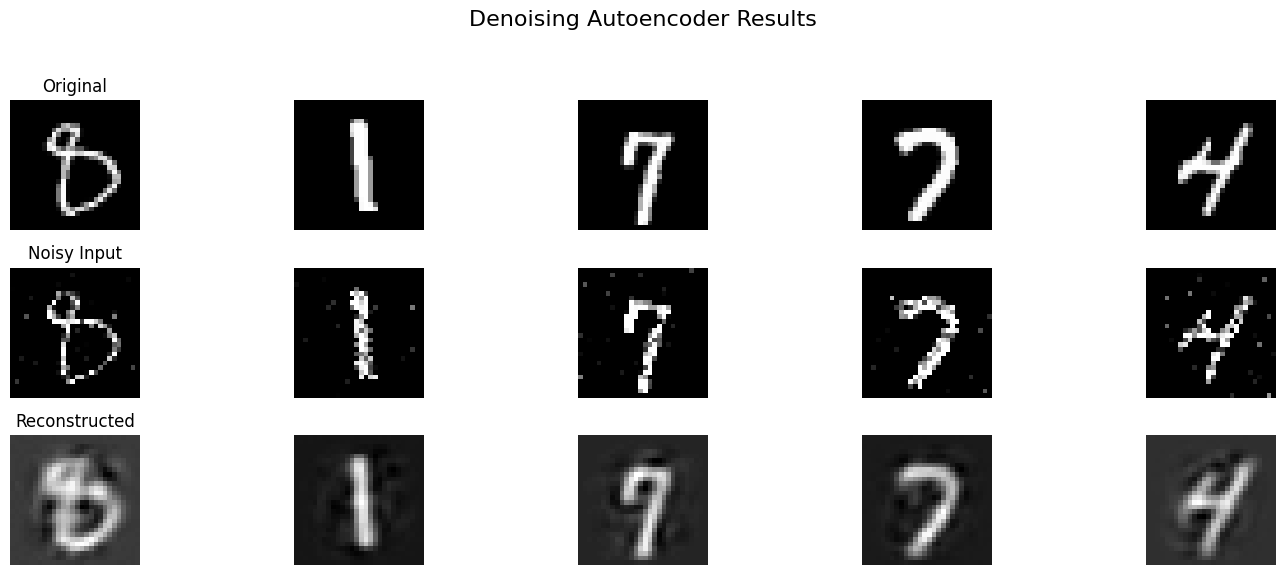

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_loss,0.06366
val_loss,0.06195


In [25]:

trainloader, testloader = setup_data_and_log_artifact()
print(f"Number of training batches: {len(trainloader)}")
print(f"Number of test batches: {len(testloader)}")
single_image = trainloader.dataset[0]
print(single_image)
print(single_image[0].shape)

model = AutoEncoder().to(device)
# print("Model summary:")
# summary(model, input_size=(1, 1, 28, 28))
wandb.watch(model, log="all", log_freq=100) 

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

train(model, trainloader, testloader, loss_fn, optimizer, device)

wandb.finish()
